In [1]:
!pip install statsmodels --upgrade

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [3]:
df=pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9639,2024-06-12,435.320007,443.399994,433.250000,441.059998,441.059998,22366200
9640,2024-06-13,440.850006,443.390015,439.369995,441.579987,441.579987,15960600
9641,2024-06-14,438.279999,443.140015,436.720001,442.570007,442.570007,13582000
9642,2024-06-17,442.589996,450.940002,440.720001,448.369995,448.369995,20790000


In [4]:
# prompt: drop Date from the X
D=df['Close']
#X = df.drop('Date', axis=1)
X=D

In [5]:
# Apply log transformation
log_series = np.log(X)
X= log_series.diff().dropna()
X

1       0.035089
2       0.017103
3      -0.025761
4      -0.017543
5      -0.026906
          ...   
9639    0.019183
9640    0.001178
9641    0.002239
9642    0.013020
9643   -0.004538
Name: Close, Length: 9643, dtype: float64

In [6]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(X, autolag='AIC')
print("1. ADF :", dftest[0])
print("2. P-Value :", dftest[1])
print("3. Num of Lags :", dftest[2])
print("4. Num of Observations Used for ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t%s: %.3f" % (key, val))

1. ADF : -52.672421441836626
2. P-Value : 0.0
3. Num of Lags : 3
4. Num of Observations Used for ADF Regression and Critical Values Calculation : 9639
5. Critical Values :
	1%: -3.431
	5%: -2.862
	10%: -2.567


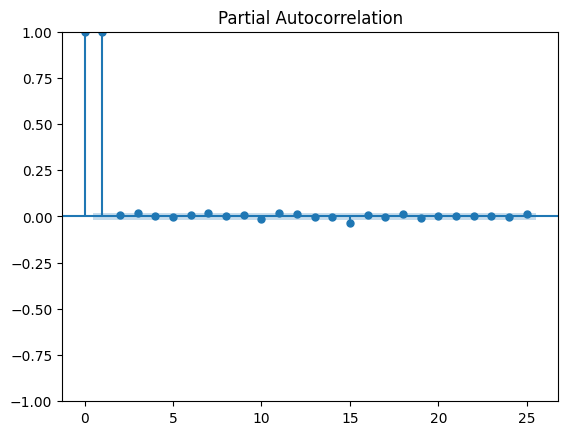

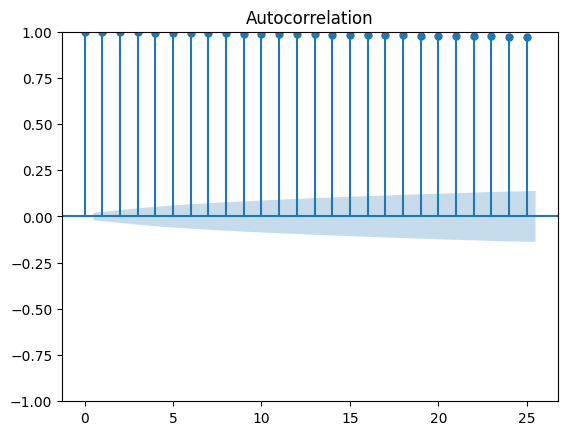

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf= plot_pacf(df['Close'],lags=25)
acf= plot_acf(df['Close'],lags=25)

In [8]:
train=X[:len(X)-7]
test=D[len(D)-7:]


In [9]:
model=AutoReg(train,lags=4).fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 9636
Model:                     AutoReg(4)   Log Likelihood               23462.479
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Mon, 29 Jul 2024   AIC                         -46912.957
Time:                        06:46:55   BIC                         -46869.920
Sample:                             4   HQIC                        -46898.362
                                 9636                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      4.479      0.000       0.001       0.001
Close.L1      -0.0202      0.010     -1.979      0.048      -0.040      -0.000
Close.L2      -0.0405      0.010     -3.973      0.0

In [11]:
pred=model.predict(start=len(train),end=len(X)-1,dynamic=False)
forecast_log = log_series.iloc[-1] + pred.cumsum()

# Reversing the log transformation
forecast = np.exp(forecast_log)
print(forecast)
print(test)
D.tail(10)

9636    446.441781
9637    446.665682
9638    447.097639
9639    447.529078
9640    447.927791
9641    448.318140
9642    448.704944
dtype: float64
9637    427.869995
9638    432.679993
9639    441.059998
9640    441.579987
9641    442.570007
9642    448.369995
9643    446.339996
Name: Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


9634    424.010010
9635    424.519989
9636    423.850006
9637    427.869995
9638    432.679993
9639    441.059998
9640    441.579987
9641    442.570007
9642    448.369995
9643    446.339996
Name: Close, dtype: float64

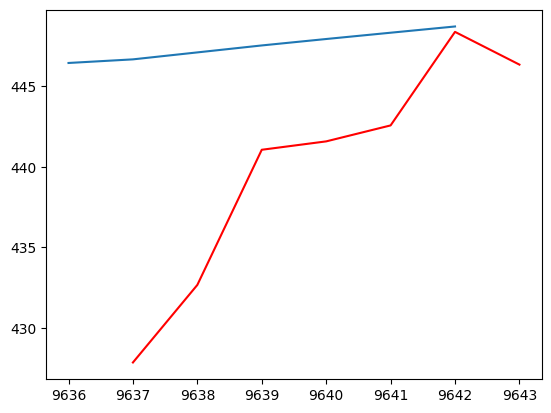

In [12]:
from matplotlib import pyplot
pyplot.plot(forecast)
pyplot.plot(test,color='red')
pyplot.show()

In [17]:
from math import sqrt
import tensorflow as tf
from sklearn.metrics import mean_squared_log_error
rmse=sqrt(mean_squared_log_error(test,forecast))
print(rmse)
print(tf.keras.metrics.mean_squared_error(test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(test, forecast).numpy())

0.021839753751221554
92.37957763685183
7.474113352958641


12.062789448275868
